### About

This project is about [a challenge from Kaggle](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/) to predict the demographic information of mobile users.

This notebook is greatly inspired by [the notebook](https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/brand-and-model-based-benchmarks).

## Data Description

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [10]:
# list the data files
os.listdir('../data')

['gender_age_test.csv', 'gender_age_train.csv', 'phone_brand_device_model.csv']

#### Gender-Age-Group

In [4]:
df_gender_age_train = pd.read_csv('../data/gender_age_train.csv')
df_gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


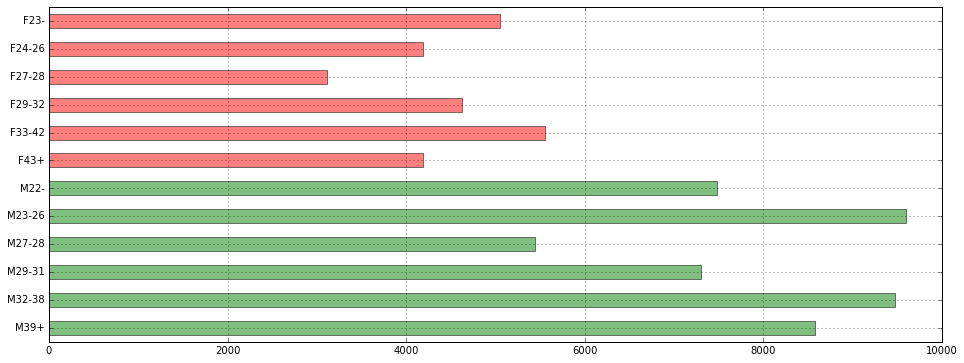

In [5]:
gender_age_group = df_gender_age_train.group.value_counts().sort_index(ascending=False)

color_array = ['g' for i in np.arange(6)] + ['r' for i in np.arange(6)]

''' plot the data in horizontal bars. '''
plt.figure()
gender_age_group.plot(kind='barh', color=color_array,
                      alpha=0.5, grid=True, figsize=(16, 6))
plt.show()

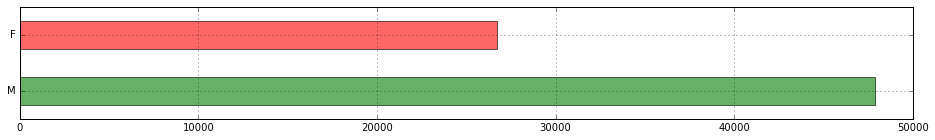

In [6]:
df_gender_age_train.gender.value_counts().plot(kind='barh',
    color=['g', 'r'], alpha=0.6, grid=True, figsize=(16, 2))

In [7]:
gender_age_dist = df_gender_age_train.groupby(['gender', 'age']).size()

age_range = np.arange(df_gender_age_train.age.min(),
                      df_gender_age_train.age.max())

gender_age_dist = gender_age_dist.unstack(level=0)

gender_age_dist = gender_age_dist.reindex(index=age_range).fillna(0)

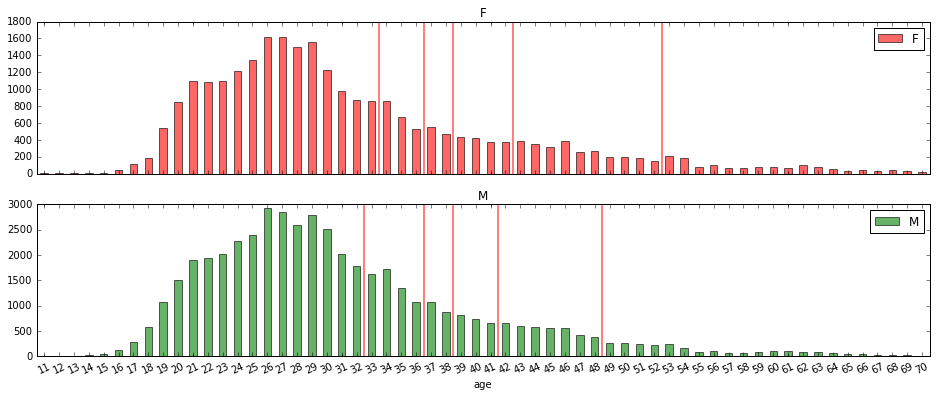

In [94]:
plt.figure()
ax1, ax2 = gender_age_dist.iloc[10:70].plot(kind='bar',
                                figsize=(16,6),
                                subplots=True,
                                color=['r', 'g'], alpha=0.6)
# xlabels = ['%i' % i for i in age_range]
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)

# plot separated lines in the subplots
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=2,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=2,color='r')

plt.show()

#### Phone Brand & Model

In [54]:
df_phone_brand_device_model = pd.read_csv('../data/phone_brand_device_model.csv')
df_phone_brand_device_model.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


##### Deduplication

In [19]:
print('unique device_id count:', df_phone_brand_device_model.device_id.nunique())
print('total records:', len(df_phone_brand_device_model))

unique device_id count: 186716
total records: 187245


Apparently, there are some **duplicated** device ids. There could be some redundant records.

Or in a worse case, the information might NOT be consistent, *i.e.* the same ```device_id```, but different brand or model names. In the following code section, we check those inconsistent devices.

In [47]:
device_id_group = df_phone_brand_device_model.groupby('device_id').size()

# first, find out the device_id that appear at least twice.
duplicate_device_ids = device_id_group[device_id_group > 1].index
duplicate_devices = df_phone_brand_device_model.loc[
    df_phone_brand_device_model.device_id.isin(duplicate_device_ids)]

# first element within each group
group_one = duplicate_devices.groupby('device_id').first()
# last element within each group
group_two = duplicate_devices.groupby('device_id').last()

# find out those devices with the same 'device_id' but different brand or model name
inconsistent_devices = (group_one != group_two).sum(axis=1).nonzero()

# show the inconsistent device information
print('Inconsistent devices:')
pd.concat((group_one.iloc[inconsistent_devices],
           group_two.iloc[inconsistent_devices]), axis=1)

Inconsistent devices:


,phone_brand,device_model,phone_brand,device_model
device_id,,,,
-7297178577997113203,华为,荣耀畅玩5X,华为,荣耀3C
-7059081542575379359,LG,Nexus 5,魅族,魅蓝Note 2
-6590454305031525112,小米,MI 3,华为,荣耀6 Plus
-5269721363279128080,三星,Galaxy Core Advance,小米,MI 3
-3004353610608679970,酷派,5891,酷派,7296
5245428108336915020,魅族,MX4,小米,MI One Plus


In [57]:
print('Length before dropping duplicates:',
      len(df_phone_brand_device_model))

# drop duplicates in place, i.e. no need to return a new copy.
df_phone_brand_device_model.drop_duplicates(
    subset='device_id', keep='first', inplace=True)

print('Length after dropping duplicates:',
      len(df_phone_brand_device_model))

Length before dropping duplicates: 186716
Length after dropping duplicates: 186716


##### Device Models Associated with Multi-Brand

We do a bit of grouping on the attributes ```device_model, phone_brand``` to see if a single device model could be **associated** with different brands. We could construct the following ```pivot_table``` with the ```'device_model'``` as the index, and each ```'phone_brand'``` as a column, each cell in the pivot table is the number of devices associated with the corresponding device_model and phone_brand.

|              | Apple |      Nokia     | ... |
|:------------:|:-----:|:--------------:|-----|
|      M8      |   0   | num_of_devices |     |
|   iPhone 6   |  ...  |       ...      | ... | 



In [124]:
model_brand_table = df_phone_brand_device_model.pivot_table(
    index=['device_model'],
    columns=['phone_brand'],
    aggfunc=len).fillna(0)

phone_brands = model_brand_table.columns

model_brand_table = model_brand_table.apply(
    lambda x: len(x.nonzero()[0]), axis=1)

# find out the device models that are associated with more than one brands.
multi_brand_device_model = model_brand_table[model_brand_table > 1]

def get_multi_brand_device_model():
    ''' Another method using the groupby() function. '''
    g = df_phone_brand_device_model.groupby(
            'device_model')['phone_brand'].apply(pd.Series.nunique)

    return g[g > 1].index


multi_brand_device_model.describe()

count    54.000000
mean      2.259259
std       0.555765
min       2.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       4.000000
dtype: float64

Encode the phone brand and the device model. Particularly, concatenating the device_model with its associated phone brand to make it unique.

In [136]:
# encode the phone_brand string column with numbers
df_phone_brand_device_model['brand'] = LabelEncoder().fit(
    df_phone_brand_device_model['phone_brand']).transform(
    df_phone_brand_device_model['phone_brand'])

df_phone_brand_device_model.head()

# encode the device_model string column with numbers.
model_brand_labels = df_phone_brand_device_model.device_model.str.cat('_' + 
                        df_phone_brand_device_model.phone_brand)
df_phone_brand_device_model['model'] = LabelEncoder().fit(
    model_brand_labels).transform(model_brand_labels)

In [137]:
df_phone_brand_device_model.head()

,device_id,phone_brand,device_model,brand,model
0,-8890648629457979026,小米,红米,51,1591
1,1277779817574759137,小米,MI 2,51,773
2,5137427614288105724,三星,Galaxy S4,15,573
3,3669464369358936369,SUGAR,时尚手机,9,1571
4,-5019277647504317457,三星,Galaxy Note 2,15,546


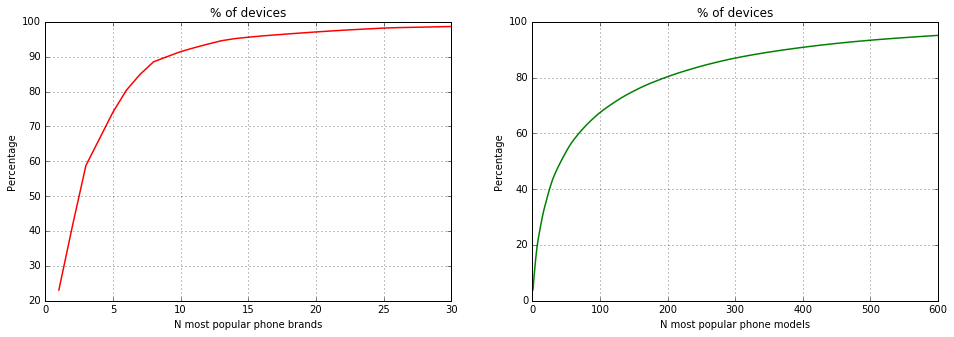

In [172]:
brand_count = df_phone_brand_device_model.brand.value_counts().sort_values(ascending=False)

# calculate the accumulative percentage.
brand_count = brand_count.cumsum() / brand_count.sum()

plt.figure()
fig, (ax_left,ax_right) = plt.subplots(1, 2, figsize=(16,5))  # sharey=True 
x_axis_data = np.arange(len(graph_data)) + 1
y_axis_data = brand_count.values*100
ax_left.plot(x_axis_data, y_axis_data, color='r', linewidth=1.5)
ax_left.set_xlabel('N most popular phone brands')
ax_left.set_ylabel('Percentage')
ax_left.set_title('% of devices')
ax_left.set_xlim(0, 30)
ax_left.grid(True)

model_count = df_phone_brand_device_model.model.value_counts().sort_values(ascending=False)
model_count = model_count.cumsum() / model_count.sum()
ax_right.plot(np.arange(len(model_count))+1, model_count*100, color='g', linewidth=1.5)
ax_right.set_xlabel('N most popular phone models')
ax_right.set_title('% of devices')
ax_right.set_ylabel('Percentage')
ax_right.set_xlim(0, 600)
ax_right.grid(True)
plt.show()


- As we could see from the upleft graph, **6** phone brands dominate around **80%** of the market share.

- From the upright graph, we could see that **80%** of the devices are of **200** different models.


In [170]:
brand_count[brand_count <= 0.82]

51     0.230869
15     0.413987
31     0.587861
13     0.664673
7      0.740933
128    0.804216
Name: brand, dtype: float64

### Events 

Explore the ```events``` data. The following graphs were inspired by [a notebook from Kaggle](https://www.kaggle.com/beyondbeneath/talkingdata-mobile-user-demographics/geolocation-visualisations).

In [3]:
df_events = pd.read_csv("../data/events.csv", dtype={'device_id': np.str})

df_events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


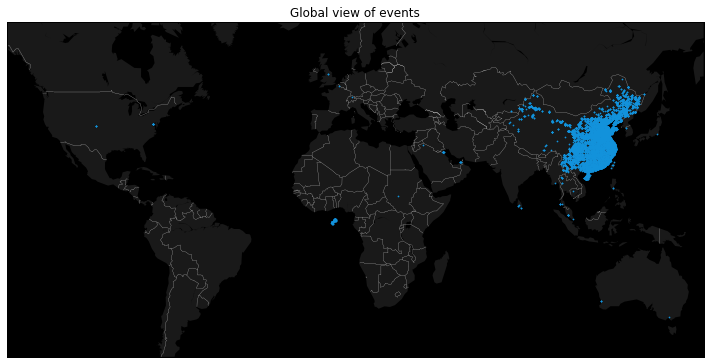

In [22]:
from mpl_toolkits.basemap import Basemap


def plot_events_on_map(longtitude, latitude, events, title):
    ''' Show the events that follow within the given ranges of longtitude and latitude '''

    event_idx = (events["longitude"] > longtitude['min']) & \
                (events["longitude"] < longtitude['max']) & \
                (events["latitude"] > latitude['min']) & \
                (events["latitude"] < latitude['max'])
    
    # Set up plot
    df_events_sample = events[event_idx].sample(n=100000)

    plt.figure(1, figsize=(13,6))

    # Mercator of World
    map = Basemap(projection='merc',
             llcrnrlat = latitude['min'],
             urcrnrlat = latitude['max'],
             llcrnrlon = longtitude['min'],
             urcrnrlon = longtitude['max'],
             lat_ts=0,
             resolution='c')

    # dark grey land, black lakes    
    map.fillcontinents(color='#191919',lake_color='#000000')
    # black background
    map.drawmapboundary(fill_color='#000000')
    # thin white line for country borders
    map.drawcountries(linewidth=0.2, color="w")

    # Plot the data
    mxy = map(df_events_sample["longitude"].tolist(),
              df_events_sample["latitude"].tolist())

    map.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

    plt.title(title)
    plt.show()


# Show the map of the entire world (almost)
longtitude = { "min": -140, "max": 160}
latitude = {"min": -50, "max": 65}

plot_events_on_map(longtitude, latitude, df_events, "Global view of events")


#### Zoom into China

Look closer into the events happened in China.

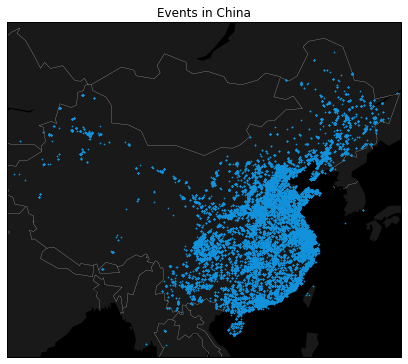

In [23]:
# Zoom into China

longtitude_china = {"min": 75, "max": 135}
latitude_china = {"min": 15, "max": 55}
plot_events_on_map(longtitude_china, latitude_china, df_events, "Events in China")

#### Zoom into Beijing


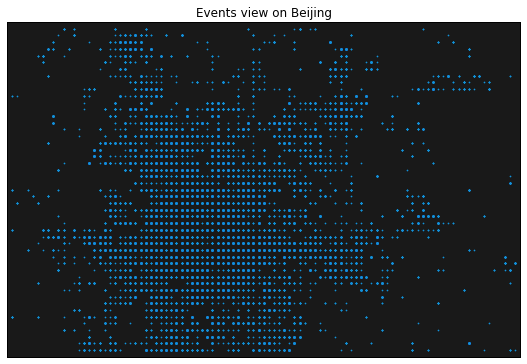

In [24]:
# Sample it down to only the Beijing region
lon_min, lon_max = 116, 117

lat_min, lat_max = 39.75, 40.25

longtitude_beijing = {"min": 116, "max": 117}
latitude_beijing = {"min": 39.75, "max": 40.25}

plot_events_on_map(longtitude_beijing, latitude_beijing, df_events, "Events view on Beijing")

## Classification

In the next code section, we first encode the label of age groups with a number, so that we could use that for the model building and model evaluation.

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

# encode the group labels with integar number of 0 to num_classes
group_label_encoder = LabelEncoder().fit(df_gender_age_train.group.values)

group_labels = group_label_encoder.transform(df_gender_age_train.group.values)

### Non-Preference Assignment

A naive strategy to predict the probability that a sample could be assigned to a group, is to assume that each group has an equal probability.

In [167]:
num_class = len(group_label_encoder.classes_)

# the assignment to each class with equal probability.
equal_pred = np.ones((len(df_gender_age_train), num_class)) / num_class

print('log_loss of non-preference prediction:', log_loss(group_labels, equal_pred))

log_loss of non-preference prediction: 2.48490664979


### Cross Validation Assignment

Another naive strategy of prediction, is to assume the probability of a sample to be assigned to a group is proportional to the *priori* propability of a group in the training dataset.

In addition, we could use the **cross validation** method to divide the dataset into ```N``` folds, then we use the ```N-1``` folds as the training dataset to do the prediction for each fold.

- Create N-folds out of the original data
- For each fold, use the rest of the folds to do the prediction.

The performance is slightly better than the non-preference assignment strategy.

In [181]:
from sklearn.cross_validation import KFold

kf = KFold(len(group_labels), n_folds=10, shuffle=True, random_state=None)

x_valid_pred = np.zeros((len(df_gender_age_train), num_class))

for train_index, test_index in kf:
    train_X = df_gender_age_train.iloc[train_index, :]
    test_X = df_gender_age_train.iloc[test_index, :]
    
    pred = train_X.groupby('group').size() / len(train_X)
    x_valid_pred[test_index, :] = pred

print('log_loss of cross validation prediction:',
      log_loss(group_labels, x_valid_pred))

log_loss of cross validation prediction: 2.42804066037
